In [1]:
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
## read in merged_fit_stats_2.json as a dictionary
with open('merged_fit_stats_2.json', 'r') as f:
    data = dict(json.load(f))
    

In [13]:
data['010'].keys()

dict_keys(['lc_Me2017_00010', 'lc_TrPi2018_00010', 'lc_nugent-hyper_00010', 'lc_nugent-hyper_00011', 'lc_nugent-hyper_00012', 'lc_nugent-hyper_00013', 'lc_nugent-hyper_00014', 'lc_nugent-hyper_00015', 'lc_nugent-hyper_00016', 'misc'])

In [28]:
kn_objects = {}

for key, value in data.items():
    ## find any key in value that starts with lc_Me2017 or lc_Bu2019lm
    for subkey, subvalue in value.items():
        if subkey.startswith('lc_Me2017') or subkey.startswith('lc_Bu2019lm'):
            kn_lightcurve = subvalue
            kn_objects[subkey] = kn_lightcurve

    # kn_objects.append(kn_lightcurve)

In [30]:
obs_length = {}
for key, value in kn_objects.items():
    obs_length[key] = len(value)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., 80.]),
 array([7.  , 7.05, 7.1 , 7.15, 7.2 , 7.25, 7.3 , 7.35, 7.4 , 7.45, 7.5 ,
        7.55, 7.6 , 7.65, 7.7 , 7.75, 7.8 , 7.85, 7.9 , 7.95, 8.  ]),
 <a list of 20 Patch objects>)

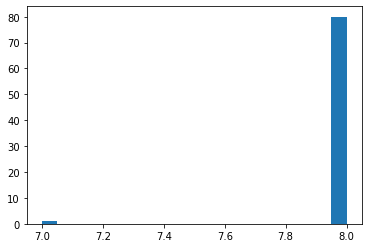

In [34]:
## plot histogram of observation length
plt.hist(obs_length.values(), bins=20)